레드벨벳 멤버들의 사진을 학습하여 멤버들의 사진을 넣었을 때 누구인지 확인하는 모델을 제작했다. 데이터 숫자는 멤버별로 100개 가량 학습하여 학습데이터가 적어 제대로 학습이 되지 않는 모습을 보였다. dropout을 없애 overfitting되도록 만들어 트레인 데이터는 잘 학습되었는지 확인했고 data augmentation을 사용했다. label smoothing을 사용했을 때 학습률이 저조하여 삭제했다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.7.0+cu101].
device:[cuda:0].


In [2]:
import os
import shutil
import glob


TARGET_PATH = "./drive/MyDrive/Colab Notebooks/boostcamp/test/redvelvet_dataset"

In [3]:
for dir_name in os.listdir(TARGET_PATH):
    breed_name = dir_name.split("-")[-1].lower()
    source_dir = os.path.join(TARGET_PATH, dir_name)
    target_dir = os.path.join(TARGET_PATH, breed_name)
    shutil.move(source_dir, target_dir) 

In [4]:
source_dir

'./drive/MyDrive/Colab Notebooks/boostcamp/test/redvelvet_dataset/yeri'

In [5]:
dataset = []
for filepath in glob.iglob(f'{TARGET_PATH}/**/*.png', recursive=True):
    breed_name = filepath.split("/")[7]
    dataset.append([filepath, breed_name])
dataset = np.array(dataset)

In [6]:
breed_name

'yeri'

In [7]:
from sklearn.model_selection import train_test_split

train_image, test_image, train_target, test_target = train_test_split(dataset[:,0], dataset[:,1], stratify=dataset[:,1])

In [8]:
DATA_PATH = "./drive/MyDrive/Colab Notebooks/boostcamp/test/dataset"
shutil.rmtree(DATA_PATH)
if not os.path.exists(DATA_PATH):
    os.mkdir(DATA_PATH)
    os.makedirs(os.path.join(DATA_PATH, "train"))
    os.makedirs(os.path.join(DATA_PATH, "test"))
    
    for breed_name in set(test_target):
        os.makedirs(os.path.join(DATA_PATH, "train", breed_name))
        os.makedirs(os.path.join(DATA_PATH, "test", breed_name))

In [10]:
import shutil
for filepath, taregt_dir in zip(train_image.tolist(), train_target.tolist()):        
    filename = filepath.split("/")[8]
    source_path = filepath
    target_dir = os.path.join(DATA_PATH, "train", taregt_dir, filename)
    shutil.copy(source_path, target_dir) 

for filepath, taregt_dir in zip(test_image.tolist(), test_target.tolist()):        
    filename = filepath.split("/")[8]
    source_path = filepath
    target_dir = os.path.join(DATA_PATH, "test", taregt_dir, filename)
    shutil.copy(source_path, target_dir) 

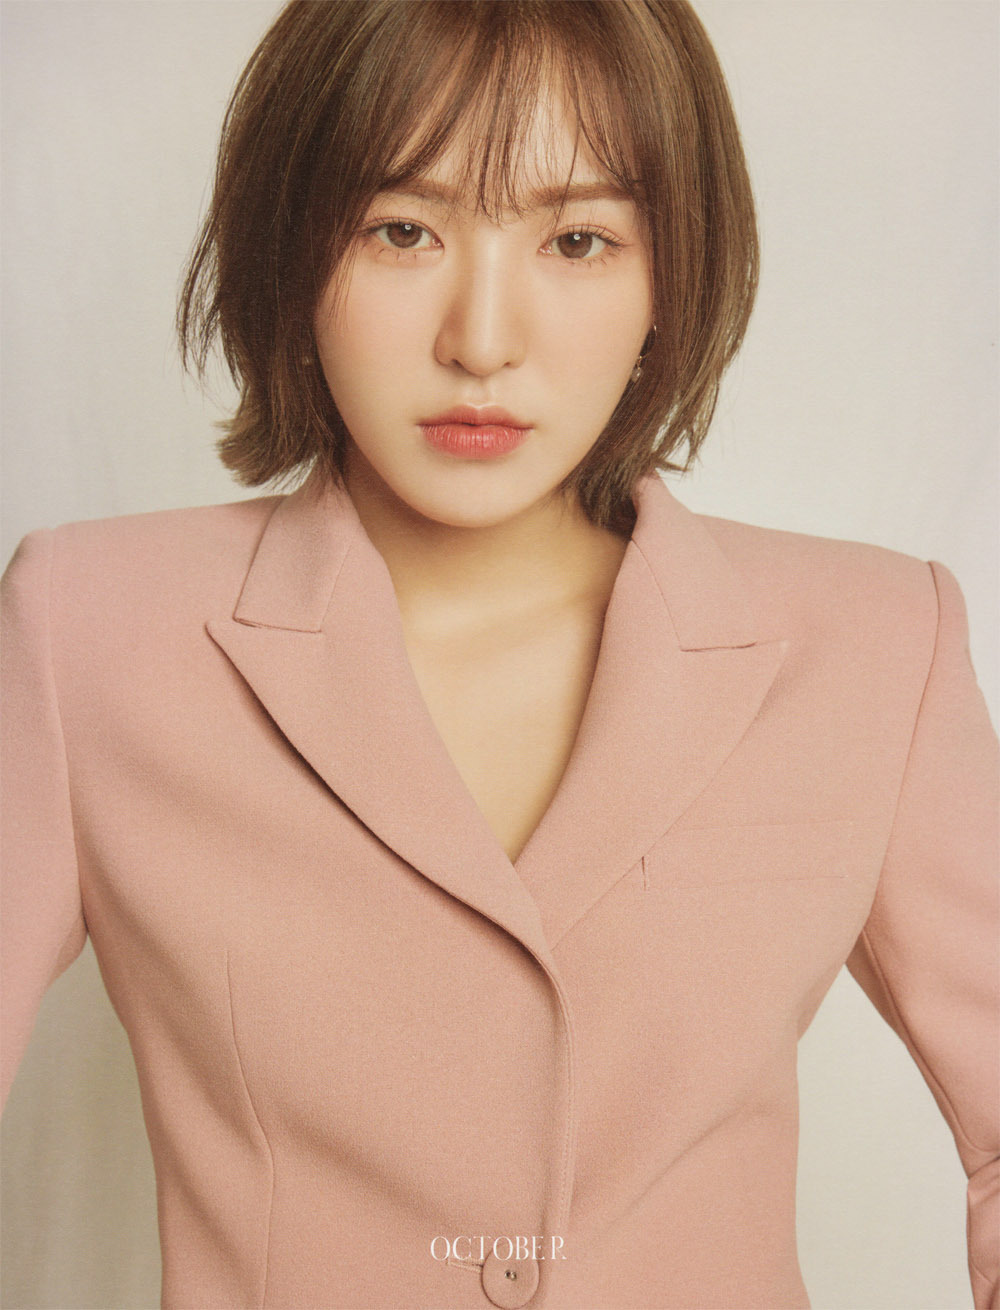

In [12]:
from PIL import Image
 
im = Image.open(target_dir)
im

In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def process(filename: str=None) -> None:
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
    image = mpimg.imread(filename)
    # <something gets done here>
    plt.figure()
    plt.imshow(image)

    
idx = np.random.choice(len(dataset), 10)

images = dataset[:, 0][idx]

for file in images:
    process(file)
    
print(dataset[:, 1][idx])

Output hidden; open in https://colab.research.google.com to view.

In [72]:
from torchvision import datasets, transforms, models

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor()])

DATASET_PATH = "./drive/MyDrive/Colab Notebooks/boostcamp/test/dataset"
# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(DATASET_PATH + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(DATASET_PATH + '/test', transform=test_transforms)

In [73]:
train_data

Dataset ImageFolder
    Number of datapoints: 355
    Root location: ./drive/MyDrive/Colab Notebooks/boostcamp/test/dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               RandomRotation(degrees=[-30.0, 30.0], resample=False, expand=False)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [74]:
import torch
BATCH_SIZE=16

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)


In [75]:
classes = ('irene','joy','seulgi','wendy','yeri')

In [86]:
class ConvolutionalNeuralNetworkClass(nn.Module):
    """
        Convolutional Neural Network (CNN) Class
    """
    def __init__(self,name='cnn',xdim=[3,224,224],
                 ksize=3,cdims=[32,64],hdims=[1024,128],ydim=5,
                 USE_BATCHNORM=False):
        super(ConvolutionalNeuralNetworkClass,self).__init__()
        self.name = name
        self.xdim = xdim
        self.ksize = ksize
        self.cdims = cdims
        self.hdims = hdims
        self.ydim = ydim
        self.USE_BATCHNORM = USE_BATCHNORM

        # Convolutional layers
        self.layers = []
        prev_cdim = self.xdim[0]
        for cdim in self.cdims: # for each hidden layer
            self.layers.append(
                nn.Conv2d(in_channels=prev_cdim,
                          out_channels=cdim,
                          kernel_size=self.ksize,
                          stride=(1,1),
                          padding=self.ksize//2)) # convlution 
            if self.USE_BATCHNORM:
                self.layers.append(nn.BatchNorm2d(cdim)) # batch-norm
            self.layers.append(nn.ReLU(True))  # activation
            self.layers.append(nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))) # max-pooling 
            #self.layers.append(nn.Dropout2d(p=0.8))  # dropout
            prev_cdim = cdim

        # Dense layers
        self.layers.append(nn.Flatten())
        prev_hdim = prev_cdim*(self.xdim[1]//(2**len(self.cdims)))*(self.xdim[2]//(2**len(self.cdims)))
        for hdim in self.hdims:
            self.layers.append(nn.Linear(prev_hdim,hdim,bias=True ))
            self.layers.append(nn.ReLU(True))  # activation
            prev_hdim = hdim
        # Final layer (without activation)
        self.layers.append(nn.Linear(prev_hdim,self.ydim,bias=True))

        # Concatenate all layers 
        self.net = nn.Sequential()
        for l_idx,layer in enumerate(self.layers):
            layer_name = "%s_%02d"%(type(layer).__name__.lower(),l_idx)
            self.net.add_module(layer_name,layer)
        self.init_param() # initialize parameters
        
    def init_param(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.BatchNorm2d): # init BN
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            
    def forward(self,x):
        return self.net(x)

C = ConvolutionalNeuralNetworkClass(
    name='cnn',xdim=[3,224,224],ksize=3,cdims=[32,64],
    hdims=[32],ydim=5).to(device)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(C.parameters(),lr=1e-3)
print ("Done.")

Done.


In [87]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx,(param_name,param) in enumerate(C.named_parameters()):
    if param.requires_grad:
        param_numpy = param.detach().cpu().numpy() # to numpy array 
        n_param += len(param_numpy.reshape(-1))
        print ("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
        print ("    val:%s"%(param_numpy.reshape(-1)[:5]))
print ("Total number of parameters:[%s]."%(format(n_param,',d')))

[0] name:[net.conv2d_00.weight] shape:[(32, 3, 3, 3)].
    val:[ 0.307  0.241 -0.21  -0.161  0.162]
[1] name:[net.conv2d_00.bias] shape:[(32,)].
    val:[0. 0. 0. 0. 0.]
[2] name:[net.conv2d_03.weight] shape:[(64, 32, 3, 3)].
    val:[-0.124 -0.011 -0.043 -0.006  0.095]
[3] name:[net.conv2d_03.bias] shape:[(64,)].
    val:[0. 0. 0. 0. 0.]
[4] name:[net.linear_07.weight] shape:[(32, 200704)].
    val:[ 0.     0.003  0.001 -0.001  0.   ]
[5] name:[net.linear_07.bias] shape:[(32,)].
    val:[0. 0. 0. 0. 0.]
[6] name:[net.linear_09.weight] shape:[(5, 32)].
    val:[-0.111 -0.249 -0.12  -0.064 -0.138]
[7] name:[net.linear_09.bias] shape:[(5,)].
    val:[0. 0. 0. 0. 0.]
Total number of parameters:[6,442,117].


In [88]:
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)
x_numpy = np.random.rand(2,3,224,224)
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = C.forward(x_torch) # forward path
y_numpy = y_torch.detach().cpu().numpy() # torch tensor to numpy array
print ("x_torch:\n",x_torch)
print ("y_torch:\n",y_torch)
print ("\nx_numpy %s:\n"%(x_numpy.shape,),x_numpy)
print ("y_numpy %s:\n"%(y_numpy.shape,),y_numpy)

x_torch:
 tensor([[[[0.704, 0.306, 0.954,  ..., 0.312, 0.151, 0.582],
          [0.515, 0.482, 0.054,  ..., 0.961, 0.820, 0.436],
          [0.588, 0.468, 0.183,  ..., 0.623, 0.147, 0.367],
          ...,
          [0.346, 0.925, 0.499,  ..., 0.924, 0.720, 0.703],
          [0.393, 0.298, 0.253,  ..., 0.974, 0.879, 0.358],
          [0.773, 0.512, 0.323,  ..., 0.110, 0.280, 0.625]],

         [[0.812, 0.116, 0.586,  ..., 0.447, 0.898, 0.355],
          [0.719, 0.347, 0.622,  ..., 0.742, 0.431, 0.807],
          [0.156, 0.087, 0.819,  ..., 0.176, 0.910, 0.305],
          ...,
          [0.081, 0.756, 0.138,  ..., 0.734, 0.213, 0.495],
          [0.500, 0.482, 0.798,  ..., 0.525, 0.062, 0.260],
          [0.673, 0.351, 0.934,  ..., 0.173, 0.764, 0.759]],

         [[0.391, 0.065, 0.561,  ..., 0.815, 0.517, 0.475],
          [0.986, 0.780, 0.868,  ..., 0.978, 0.565, 0.804],
          [0.455, 0.264, 0.168,  ..., 0.450, 0.934, 0.423],
          ...,
          [0.362, 0.853, 0.996,  ..., 0.9

In [89]:
def func_eval(model,data_iter,device):
    with torch.no_grad():
        n_total,n_correct = 0,0
        model.eval() # evaluate (affects DropOut and BN)
        for batch_in,batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model(batch_in.view(-1,3,224,224).to(device))
            _,y_pred = torch.max(model_pred.data,1)
            n_correct += (y_pred==y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        model.train() # back to train mode 
    return val_accr
print ("Done")

Done


In [90]:
C.init_param() # initialize parameters
train_accr = func_eval(C,train_loader,device)
test_accr = func_eval(C,test_loader,device)
print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr,test_accr))

train_accr:[0.194] test_accr:[0.218].


In [91]:
print ("Start training.")
C.init_param() # initialize parameters
C.train() # to train mode 
EPOCHS,print_every = 30,1
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_in,batch_out in train_loader:
        # Forward path
        y_pred = C.forward(batch_in.view(-1,3,224,224).to(device))
        loss_out = loss(y_pred,batch_out.to(device))
        # Update
        optm.zero_grad()      # reset gradient 
        loss_out.backward()     # backpropagate
        optm.step()      # optimizer update
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(train_loader)
    # Print
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        train_accr = func_eval(C,train_loader,device)
        test_accr = func_eval(C,test_loader,device)
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
               (epoch,loss_val_avg,train_accr,test_accr))
print ("Done")

Start training.
epoch:[0] loss:[7.568] train_accr:[0.186] test_accr:[0.185].
epoch:[1] loss:[1.617] train_accr:[0.251] test_accr:[0.235].
epoch:[2] loss:[1.586] train_accr:[0.285] test_accr:[0.210].
epoch:[3] loss:[1.601] train_accr:[0.315] test_accr:[0.210].
epoch:[4] loss:[1.559] train_accr:[0.304] test_accr:[0.202].
epoch:[5] loss:[1.541] train_accr:[0.375] test_accr:[0.193].
epoch:[6] loss:[1.513] train_accr:[0.346] test_accr:[0.235].
epoch:[7] loss:[1.491] train_accr:[0.377] test_accr:[0.176].
epoch:[8] loss:[1.489] train_accr:[0.363] test_accr:[0.244].
epoch:[9] loss:[1.472] train_accr:[0.394] test_accr:[0.235].
epoch:[10] loss:[1.494] train_accr:[0.437] test_accr:[0.244].
epoch:[11] loss:[1.400] train_accr:[0.479] test_accr:[0.235].
epoch:[12] loss:[1.353] train_accr:[0.487] test_accr:[0.286].
epoch:[13] loss:[1.313] train_accr:[0.487] test_accr:[0.303].
epoch:[14] loss:[1.320] train_accr:[0.544] test_accr:[0.277].
epoch:[15] loss:[1.304] train_accr:[0.490] test_accr:[0.294].
ep

In [97]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

In [98]:
images

tensor([[[[0.545, 0.545, 0.553,  ..., 0.435, 0.427, 0.416],
          [0.557, 0.565, 0.565,  ..., 0.447, 0.443, 0.435],
          [0.561, 0.573, 0.576,  ..., 0.467, 0.459, 0.451],
          ...,
          [0.424, 0.435, 0.451,  ..., 0.341, 0.329, 0.325],
          [0.404, 0.412, 0.431,  ..., 0.325, 0.314, 0.314],
          [0.392, 0.400, 0.408,  ..., 0.314, 0.310, 0.302]],

         [[0.678, 0.675, 0.682,  ..., 0.573, 0.573, 0.557],
          [0.686, 0.690, 0.694,  ..., 0.584, 0.584, 0.573],
          [0.694, 0.698, 0.702,  ..., 0.600, 0.592, 0.580],
          ...,
          [0.569, 0.576, 0.592,  ..., 0.471, 0.463, 0.451],
          [0.553, 0.561, 0.576,  ..., 0.451, 0.439, 0.439],
          [0.541, 0.549, 0.557,  ..., 0.443, 0.435, 0.424]],

         [[0.706, 0.706, 0.710,  ..., 0.612, 0.604, 0.600],
          [0.718, 0.718, 0.718,  ..., 0.624, 0.624, 0.612],
          [0.722, 0.725, 0.733,  ..., 0.639, 0.635, 0.624],
          ...,
          [0.580, 0.592, 0.612,  ..., 0.498, 0.490,

In [99]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(title)
    return ax

In [100]:
n_sample = 16
sample_indices = np.random.choice(len(test_data.targets), n_sample, replace=False)
test_x = images[:n_sample]
test_y = labels[:n_sample]

In [101]:
with torch.no_grad():
    C.eval()
    y_pred = C.forward(test_x.view(-1, 3, 224, 224).type(torch.float).to(device))
    
y_pred = y_pred.argmax(axis=1)

plt.figure(figsize=(20, 20))

for idx in range(n_sample):
    ax = plt.subplot(4, 4, idx+1)
    title = f"Predict: {classes[y_pred[idx]]}, Label: {classes[test_y[idx]]}"
    imshow(test_x[idx], ax, title)

plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [102]:
y_pred

tensor([2, 2, 4, 0, 2, 0, 1, 0, 3, 0, 0, 4, 3, 0, 4, 4], device='cuda:0')